In [1]:
import pandas as pd
import numpy as np
import random
import math
from parse import *
import os
import sklearn
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
#%matplotlib auto
import matplotlib.image as mpimg 
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection
from collections import defaultdict
import datetime
from datetime import timedelta
import argparse
import helper


In [2]:
'''
cmd不方便调试，就建了一个类充当参数输入的接口
'''
class Myclass():
    MinCountOfPoints=6 
    MinCountOfPointsForAll=-1  
    SizeOfGrid='0.5' # 不需要调 
    figure='floorplan01.png'
    path='./results_tag1/'
    res='./figures/'
    bySecond=False
    IntervalOfMinutesOrSeconds=1 # 1分钟 1个点  
    setConfig=True

arguments=Myclass()


In [3]:

##########################################
# Choose Family
##########################################
family_config = helper.chooseFamily()

max_x = family_config.size[1]
min_x = family_config.size[0]
max_y = family_config.size[3]
min_y = family_config.size[2]


unit = float(arguments.SizeOfGrid)  #网格单元长宽m
column_num = int((max_x-min_x)//unit)
row_num = int((max_y-min_y)//unit)
map_img = mpimg.imread(arguments.figure)

# time epsilon to select the data point
epsilon = timedelta(minutes=10)
min_count = arguments.MinCountOfPoints

# define time
year = 2022
input_path = arguments.path
res_path = arguments.res
C = 0



"""
File Path Creation
"""
def createPath(dirName):
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")
 
"""
Grid Generator
"""
def collectData(dict_df,key):
    df = dict_df[key]

    xs = []
    ys = []
    ts = []
    for i in range(len(df['time'])):
        ts.append(df['time'][i])
        xs.append(df['x值'][i])
        ys.append(df['y值'][i])
    c={ "time":ts,"x":xs,'y':ys}
    data= pd.DataFrame(c)
    return data

##########################################
# Data pre-view
##########################################


##########################################
# Data re-clean
##########################################

"""
Shift the data/position accoding to the prevision and family configuration
"""
def shift(family,df):
    for scenario in family.scenario:
        # make sure that in each scenario
        # there is only one shift linearly
        recordsInRoom = defaultdict(list)
        if scenario.name == "Shift":
            zones = scenario.zones
            for index, row in df.iterrows():
                x = row['x值']
                y = row['y值']
                m = "DoNothing"
                f = -1
                for zone in scenario.zones:
                    if helper.inZone(x,y,zone):
                        m = zone.method
                        if m == "DoNothing":
                            break
                        # print("===============> use:"+m)
                        if m.endswith("Linearly"):
                            recordsInRoom[(m,zone)].append(index)
                        else:
                            f = helper.methods[m]
                            # deal with simple shift
                            
                            x,y = f(x,y,zone)
                            df.at[index,'x值'] = x
                            df.at[index,'y值'] = y
                        break # necessary !
            # print(recordsInRoom)
            # deal with recordsInRoom
            for key in recordsInRoom.keys():
                indices = recordsInRoom[key]
                m = key[0]
                zone = key[1]
                f = helper.methods[m]
                temp_df = df.iloc[indices]
                points = []
                for i,r in temp_df.iterrows():
                    # print(i,r)
                    x = r['x值']
                    y = r['y值']
                    
                    points.append([x,y])
                new_points = f(points,zone)
                print(points)
                print(new_points)
                
                for i in range(len(indices)):
                    index = indices[i]
                    df.at[index,'x值'] = new_points[i][0]
                    df.at[index,'y值'] = new_points[i][1]
        else:
            continue
    return df

def collectDataAllInOne(df):
    xs = []
    ys = []
    ts = []
    for i in range(len(df['time'])):
        ts.append(df['time'][i])
        xs.append(df['x值'][i])
        ys.append(df['y值'][i])
    c={ "time":ts,"x":xs,'y':ys}
    data= pd.DataFrame(c)
    return data

def generalID(x,y,column_num,row_num):
    # 若在范围外的点，返回-1
    if x <= min_x or x >= max_x or y <= min_y or y >= max_y:
        return -1
    # 把x范围根据列数等分切割
    column = (max_x - min_x)/column_num
    # 把y范围根据行数数等分切割
    row = (max_y - min_y)/row_num
    # 二维矩阵坐标索引转换为一维ID，即： （列坐标区域（向下取整）+ 1） + （行坐标区域 * 列数）
    return int((x-min_x)//column)+ 1 + int((y-min_y)//row) * column_num

# 去除出门不在家的点
def WashData(data):
    del_list=[]
    for idx,row in data.iterrows():
        if row['label']==325:
            del_list.append(idx)
    for i in del_list:
        data=data.drop(i)
    data.reset_index(inplace=True,drop=True)
    return data

# s=0.5m 门口网格为325
def createGrid(data,figName):
    # add label id to the data    label: 当前数据处于哪一个网格
    data['label'] = data.apply(lambda x: generalID(x['x'], x['y'],column_num,row_num), axis = 1)
    data = WashData(data)
    # count values
    groups = data['label'].value_counts() # 统计网格中的点数
    groups[325]=0   # 删去门口对应的网格中所有点数 
    
    # re-organize the grid
    grids = np.zeros([row_num,column_num])
    for i in groups.index:
        r = (i-1)//column_num  # e.g. (6 - 1) // 12 = 0; (13-1) // 12 = 1; (12-1) // 12 = 0
        c = i - column_num * r - 1 # e.g. 6 - 0 * 12 - 1= 6; 13 - 1 * 12 -1= 0; 12 - 0 * 12 - 1 = 11
        # \sqrt{当前网格中的点数/最大网格中的点数}
        grids[r,c] = math.sqrt(groups[i])/math.sqrt(max(groups))  # Do a sqrt to make the heatmap clearer !!!
    
    
    #data.to_excel (res_path+figName+"_dataWithLabel.xls", index = False, header=True)
   
    return groups,grids


def createScatter(data_collection_array,figName):
    fig,ax0 = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
    plt.imshow(map_img,extent=[min_x-0.1,max_x,min_y-0.1,max_y]) # 0.3 is used to balance the influence of wight space suround the image
    #ax1 = fig.add_axes()
    ax0.scatter(data_collection_array[:,0],data_collection_array[:,1],s=20)
    fig.savefig(res_path+figName+"_scatter.png",dpi=300)
    plt.close()

"""
Heatmap
"""
def createHeatmap(grids,figName):
    fig, ax = plt.subplots(figsize=(max_x-min_x,max_y-min_y)) #column_num*0.5,row_num*0.5))
    with sns.axes_style("white"):
        ax = sns.heatmap(grids, cmap='Reds',linewidths=.0,alpha=.7,xticklabels =False,square = True,yticklabels =False,mask=(grids==0.),center=0.5)
    ax.invert_yaxis()
    plt.imshow(map_img,zorder = 0,  extent=[-0.1,(max_x-min_x)/unit-0.2,-0.1,(max_y-min_y)/unit-0.3] )#extent=[x_left/unit,x_right/unit,y_down/unit,y_up/unit])
    #plt.show()
    fig.savefig(res_path+figName+".png",dpi=300)
    plt.close()


# Slice By Time
"""
slice by time, which should be continous according to epsilon
"""
def sliceByTime(time_list):
    max_interval = 1 # 该区域内的最长连续停留时间
    times_in_zone = []
    temp_count = 1
    start_time = time_list[0]
    end_time = time_list[0]
    for i in range(1,len(time_list)):
        t1 = time_list[i-1]
        t2 = time_list[i]
        # time_list中前后两个数据的时间差
        time_delta = timedelta(hours=t2.hour,minutes=t2.minute) - timedelta(hours=t1.hour,minutes=t1.minute)
        if time_delta >= epsilon: # 时间差大于设定值，即在此期间离开该zone，停止计时
            max_interval = max(temp_count,max_interval)
            temp_count = 1
            end_time = t1
            times_in_zone.append([start_time,end_time])
            start_time = t2 # 重设初始时间，开始下一轮计时
        else: # 时间差小于设定值，此期间内一直在该zone中，故计时+1分钟
            temp_count += 1
    max_interval = max(max_interval,temp_count)
    end_time = time_list[-1]
    times_in_zone.append([start_time,end_time])
    return max_interval,times_in_zone

"""
get the data of corresponding zone
results: key=zone名称 value=最大连续停留时长
details: key=zone名称 value=所有停留时段 times_in_zone=[[start1,end1],[start2,end2],.....]
"""
def getTimeIntervalsForZones(dict_zones,data):
    result = {}
    details = {}
    for zone in dict_zones:
        labels = dict_zones[zone]
        data_zone = data.loc[data['label'].isin(labels)] # 在每个zone网格中的数据
        time_list = data_zone['time'].tolist() # 时间段
        result[zone],details[zone] = sliceByTime(time_list)

    print("time interval in all zones", result)
    return result,details

"""
Heatmap by Time
"""
# 无标签的区域分割
def createHeatmapByTime(dict_zones,figName):
    # re-organize the grid
    new_grids = np.zeros([row_num,column_num])
    zone_grids = np.zeros([row_num,column_num])
    for zone in dict_zones.keys():
        for label in dict_zones[zone]:
            r = (label-1)//column_num  # e.g. (6 - 1) // 12 = 0; (13-1) // 12 = 1; (12-1) // 12 = 0
            c = label - column_num * r - 1 # e.g. 6 - 0 * 12 - 1= 6; 13 - 1 * 12 -1= 0; 12 - 0 * 12 - 1 = 11
            new_grids[r,c] = groups[label] # Do a sqrt to make the map clearer !!!
            zone_grids[r,c] = zone
    #specify size of heatmap
    fig, ax = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
    ax = sns.heatmap(new_grids, cmap='GnBu',linewidths=0,alpha=0.5,xticklabels =False,square = True,annot=zone_grids,yticklabels =False,mask=(new_grids==0.),center=0.5)
    ax.invert_yaxis()
    #plt.show()
    plt.imshow(map_img,zorder = 0, extent=[-0.1,(max_x-min_x)/unit-0.2,-0.1,(max_y-min_y)/unit-0.3] ) # extent=[x_left/unit,x_right/unit,y_down/unit,y_up/unit])
    fig.savefig(res_path+figName+"_temporal.png",dpi=300)
    plt.close(fig)
    return new_grids

"""
Don't show data on the heatmap by time
"""
# 有标签的区域分割
def createHeatmapByTime2(new_grids,figName):
    fig, ax = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
    ax = sns.heatmap(new_grids, cmap='GnBu',linewidths=0,alpha=0.5,xticklabels =False,square = True,annot=False,yticklabels =False,mask=(new_grids==0.),center=0.5)
    ax.invert_yaxis()
    #plt.show()
    plt.imshow(map_img,zorder = 0, extent= [-0.1,(max_x-min_x)/unit-0.2,-0.1,(max_y-min_y)/unit-0.3])# [x_left/unit,x_right/unit,y_down/unit,y_up/unit])
    fig.savefig(res_path+figName+"_temporal02.png",dpi=300)
    plt.close(fig)

"""
Time line
"""

def storeTimeLine(timeline,filename):
    dict_zone_timelines = defaultdict(list)
    starts = []
    ends = []
    zones = []
    for s,e,z in timeline:
        if s == e : continue
        starts.append(s)
        ends.append(e)
        zones.append(z)
    dict_zone_timelines['Zone'] = zones
    dict_zone_timelines['Start'] = starts
    dict_zone_timelines['End'] = ends
    # print(dict_zone_timelines)
    df = pd.DataFrame.from_dict(dict_zone_timelines)
    df.sort_values(by=['Zone'])
    helper.saveDFtoWB(df,filename)


def createTimeLine(figName,details):
    timeline = []
    for zone in details:
        for t in details[zone]:
            parsed = parse("{}_{}",figName)
            my_date = parsed[1]
            #datetime.time to datetime.datetime
            date = str(dt.datetime.strptime(my_date, '%Y-%m-%d').date())
            # NOTE : start from 6 am to mid-night
            start = dt.time(6,0,0)
            end = dt.time(23,59,59)
            s = pd.to_datetime(date + " " + start.strftime("%H:%M:%S"))
            e = pd.to_datetime(date + " " + end.strftime("%H:%M:%S"))
            timeline.append((s, s, zone))
            timeline.append((e, e, zone))
            t0 = pd.to_datetime(date + " " + t[0].strftime("%H:%M:%S"))
            t1 = pd.to_datetime(date + " " + t[1].strftime("%H:%M:%S"))
            timeline.append((t0, t1, zone))

    storeTimeLine(timeline,res_path+figName+"_time.xlsx")

    colormapping = {}
    for zone in details:
        colormapping[zone] = "C"+str(zone)
    verts = []
    colors = []
    for d in timeline:
        v =  [(mdates.date2num(d[0]), d[2]-.4),
              (mdates.date2num(d[0]), d[2]+.4),
              (mdates.date2num(d[1]), d[2]+.4),
              (mdates.date2num(d[1]), d[2]-.4),
              (mdates.date2num(d[0]), d[2]-.4)]
        verts.append(v)
        colors.append(colormapping[d[2]])
    bars = PolyCollection(verts, facecolors=colors)
    fig, ax = plt.subplots(figsize=(9,5))
    ax.add_collection(bars)
    ax.autoscale()
    loc = mdates.HourLocator(byhour=[6,8,10,12,14,16,18,20,22])
    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
    ax.set_yticks(list(details.keys()))
    ax.set_yticklabels(list(details.keys()),fontsize=16)
    # ax.annotate('race interrupted', (61, 25),
    #             xytext=(0.8, 0.9), textcoords='axes fraction',
    #             arrowprops=dict(facecolor='black', shrink=0.05),
    #             fontsize=16,
    #             horizontalalignment='right', verticalalignment='top')
    print(list(details.keys()))
    # plt.show()
    fig.savefig(res_path+figName+"_time.png",dpi=300)
    plt.close(fig)






==>Familiy choices :<==
1 :ParentsOfSun
2 :UncleOfSun
3 :AuntOfSun
1
Family of ParentsOfSun is chosen!

Trace familes:
	ParentsOfSun
	size of house : [-2.665, 13.505, -2.2, 10.44]
		Scenario=Shift
			zone 1: OutDoor
				{ x : [-1000.0,-0.415],y : [-1000.0,1000.0] => Delete
			zone 2: OutCanteen
				{ x : [-0.415,1.17],y : [6.773,1000.0] => MoveToDown
			zone kitchen: InKitchen
				{ x : [1.17,3.6],y : [6.785,10.44] => MoveToLeftLinearly
			zone 3: OutKitchen
				{ x : [1.17,3.6],y : [10.44,1000.0] => MoveToDown
			zone 4: OutKitchen
				{ x : [3.6,1000.0],y : [10.44,1000.0] => MoveToLeftDown
			zone 5: OutCanteen
				{ x : [3.6,1000.0],y : [5.37,6.785] => MoveToLeft
			zone 6: OutBalcony
				{ x : [-0.415,6.8],y : [-1000.0,-2.2] => MoveToUp
			zone 7: OutBedRoom
				{ x : [4.115,1000.0],y : [1.085,5.37] => MoveToLeft


In [4]:
"""
Read Data
"""
n = arguments.IntervalOfMinutesOrSeconds
if n == 1:
    if arguments.bySecond:
        end_suffix = '_dataBySecond.xlsx'
    else:
        end_suffix = '_dataByMinute.xlsx'
else:
    if arguments.bySecond:
        end_suffix = '_dataBy'+str(n)+'Seconds.xlsx'
    else:
        end_suffix = '_dataBy'+str(n)+'Minutes.xlsx'
    

# read files
files = [f for f in os.listdir(input_path) if f.endswith(end_suffix)]
# read data
print("Files read are :", files)
tags_order = []
all_points_array = []
dict_df = {}
list_df = []
# data collection for one
data_collection = []

if arguments.MinCountOfPointsForAll == -1:
    C = min_count * len(files)
else:
    C = arguments.MinCountOfPointsForAll

    

for f in files:
    df = pd.read_excel(open(input_path+f,'rb')) 
    ori_df = df.copy()# store the non-shifted points
    # shift data
    if arguments.setConfig :
        print("==========>Start Shifting<============")
        df = shift(family_config,df)
        # print(df_temp)

    # one copy of df
    df_copy = df.copy()

    parsed = parse("{}_{}_{}",f)
    my_date = str(year)+'-'+parsed[1][:2]+'-'+parsed[1][2:]
    date = str(dt.datetime.strptime(my_date, '%Y-%m-%d').date())

    points = []
    old_points = []
    key = parsed[0]+"_"+my_date 

    for i in range(len(df['hour'])):
        point = [df['x值'][i],df['y值'][i]]
        old_point = [ori_df['x值'][i],ori_df['y值'][i]]
        points.append(point)
        old_points.append(old_point)
        data_collection.append(point)
            
        # define new time for all in one
        # TODO : if necessary, to change all dataframe time
        new_time = pd.to_datetime(date + " " + df['time'][i].strftime("%H:%M:%S"))
        df_copy['time'] = new_time

    points_array = np.array(points)
    old_points_array = np.array(old_points)
    
    # create non-shifted scatter
    # createScatter(old_points_array,key)
    
    # create shifted scatter
    createScatter(points_array,key)

    tags_order.append(parsed[0])
    all_points_array.append(points_array)
        
    dict_df[key] = df
    #print(all_points_array)
    list_df.append(df_copy)

'''
dict_df:
key: 'tag0_2022_2_19'等
data: 当天的时间-点值 dataframe
'''

Files read are : ['tag1_0214_dataByMinute.xlsx', 'tag1_0205_dataByMinute.xlsx', 'tag1_0213_dataByMinute.xlsx', 'tag1_0206_dataByMinute.xlsx', 'tag1_0209_dataByMinute.xlsx', 'tag1_0207_dataByMinute.xlsx', 'tag1_0210_dataByMinute.xlsx', 'tag1_0211_dataByMinute.xlsx', 'tag1_0208_dataByMinute.xlsx', 'tag1_0202_dataByMinute.xlsx', 'tag1_0203_dataByMinute.xlsx', 'tag1_0204_dataByMinute.xlsx', 'tag1_0212_dataByMinute.xlsx']
==========>Start Shifting<============
k is : 9
The adjusted slope is : 0.5601033360257696
[[2.877974494591102, 6.832984343434346], [2.7435825246493066, 7.181411279461269], [2.6826889145880206, 7.50659629629629], [2.789414167380335, 8.583333333333325], [2.8267642579013597, 8.589523214285713], [2.0016856388613844, 9.391652777777779], [1.8557222388656127, 8.920087962962958], [2.571222829615386, 8.669779497354494], [3.1069050853313547, 8.555095833333338], [2.988622059842633, 8.700500000000014], [2.7279563586482416, 9.627538095238096], [2.532344555930502, 9.740833333333324], [

==========>Start Shifting<============
k is : 4
The adjusted slope is : 1.6273373867156191
[[3.089640515799409, 6.821926388888894], [1.646314089327368, 7.996499999999997], [1.17, 8.26499999999999], [1.17, 8.318208333333324], [1.17, 8.496805555555564], [1.2004948141456222, 7.897937962962961], [2.070742176393279, 7.894535648148152], [1.367604658627876, 7.997068518518519], [2.118655047653638, 7.234656216931219], [1.6571034661638426, 7.881906613756614], [1.17, 8.496748082010582], [1.8302397637757566, 8.097375000000001], [2.9830109331383143, 7.088863888888885], [3.6, 6.853999999999998], [3.6, 6.853999999999998], [3.6, 6.853999999999998], [3.6, 6.853999999999998], [3.6, 6.853999999999998], [3.06079996558448, 7.101875000000003], [1.6461956521738923, 8.680000000000005], [1.6461956521738923, 8.680000000000005], [1.6461956521738923, 8.680000000000005], [1.6461956521738923, 8.680000000000005], [1.6461956521738923, 8.680000000000005], [1.204001548697939, 8.869999999999997], [1.2527331288432992, 8.

==========>Start Shifting<============
k is : 0
The adjusted slope is : 0
[[3.392500000000004, 7.431249999999992], [3.34894444444444, 7.278195833333329], [3.5615832010582, 7.868852645502642], [3.6, 7.818812500000003]]
[[3.392500000000004, 7.431249999999992], [3.34894444444444, 7.278195833333329], [3.5615832010582, 7.868852645502642], [3.6, 7.818812500000003]]
==========>Start Shifting<============
k is : 4
The adjusted slope is : 0.4262743497253208
[[3.6, 8.76024444444444], [2.6829621192827067, 8.210644444444446], [3.066124210983359, 8.107535185185194], [3.331942161800918, 8.949195833333324], [2.645643141406335, 7.598037962962962], [2.1920766650837353, 8.0], [3.2401078689265352, 8.87092857142857], [3.5822255149480733, 9.053690740740738], [3.6, 8.446041666666662], [3.4036230578060387, 8.74527023809523], [3.3667306348953314, 8.70966666666667], [2.9839539620991498, 8.957183333333342], [2.843900122460123, 7.550000000000008], [2.843900122460123, 7.550000000000008], [3.340400326560351, 8.824

==========>Start Shifting<============
k is : 9
The adjusted slope is : 0.5134844857989556
[[3.457198563572401, 6.877393650793652], [3.2123455929342786, 9.136], [2.3108269712393, 7.453798148148151], [1.2979071210245343, 7.620000000000004], [2.7229967879560713, 8.195535185185184], [2.8312351555056403, 6.85430092592593], [3.547807455817308, 8.135004629629632], [3.6, 9.384881018518518], [2.469992359320136, 8.687826190476187], [2.908939994345672, 8.617991666666663], [2.941658060165975, 8.894158267195767], [3.3237494386915287, 8.83472222222223], [2.7421517235185955, 8.903643055555552], [2.595898936136229, 8.749733796296296], [3.1745177109957803, 8.961591137566144], [2.602581020906581, 8.86048412698413], [2.492812253279835, 8.541666666666666], [3.242903149745948, 8.683244444444444], [2.8940380113368995, 9.056350529100529], [3.1128946076648782, 8.187422619047615], [3.6, 9.572666666666665], [2.831578469649066, 9.017555555555548], [3.150239942771431, 9.582022222222227], [3.6, 9.509911904761905]

==========>Start Shifting<============
k is : 13
The adjusted slope is : 0.4843627058082184
[[3.6, 7.834090277777779], [2.73422206943178, 7.055000000000005], [3.1770454022611956, 8.324472222222214], [3.4399175187342435, 9.42439999999999], [2.4631328962846686, 9.884400000000001], [2.330741052581641, 9.870000000000003], [1.47534370449695, 7.544862698412697], [2.210234724865024, 8.931666666666668], [2.9357243871144516, 8.882776851851851], [3.399980945149926, 6.823750000000005], [3.0515393126654398, 8.194540277777778], [2.870463126645581, 9.096402380952384], [3.286107211256077, 9.052003703703708], [3.592605725460562, 9.029999999999985], [3.571522392127226, 9.029999999999985], [3.3409688015356163, 9.082909523809528], [3.207921415466673, 7.81437546296296], [2.6232558025526056, 6.833333333333329], [2.6232558025526056, 6.833333333333329], [2.6232558025526056, 6.833333333333329], [2.6232558025526056, 6.833333333333329], [2.6232558025526056, 6.833333333333329], [2.6232558025526056, 6.83333333333

==========>Start Shifting<============
k is : 7
The adjusted slope is : 0.5244081965498555
[[2.7443027358123215, 7.432666666666663], [2.7701665001568863, 7.699999999999992], [2.819447006408832, 7.512166666666662], [3.6, 9.058144841269845], [2.5310132714483506, 8.69877222222222], [2.39375321834401, 8.427559722222224], [2.9218589995200084, 8.049063095238093], [3.6, 7.471344973544974], [3.4002519306124834, 7.834147222222227], [2.6612856676036114, 7.907222023809528], [2.831967082279856, 8.741236111111112], [2.931848323512583, 9.06546726190476], [2.7520808019935012, 8.85066666666668], [2.466969927287118, 8.969583333333345], [2.6609013612540235, 9.052738888888893], [2.5441582764246453, 9.516666666666655], [2.9098843866854156, 9.337833333333341], [2.6497329816275683, 8.694977314814821], [2.4945305331940926, 9.160000000000007], [2.4945305331940926, 9.160000000000007], [2.4945305331940926, 9.160000000000007], [2.4945305331940926, 9.160000000000007], [2.4945305331940926, 9.160000000000007], [2.4

==========>Start Shifting<============
k is : 19
The adjusted slope is : 0.36550174281246034
[[3.186632782552801, 7.732813271604931], [3.066353558963073, 8.08999999999999], [3.0105765501554185, 8.238500000000007], [2.912161199756529, 8.58299999999999], [2.6656019257164827, 8.788055555555555], [2.6456492845110064, 8.629999999999997], [2.6456492845110064, 8.629999999999997], [2.6456492845110064, 8.629999999999997], [2.8811102139531, 8.630638888888887], [2.9362889179082607, 8.888166666666656], [3.0960088351673143, 8.781589219576722], [3.497462353985728, 8.064166666666678], [3.4434433330095904, 8.171833333333327], [3.4869792370721022, 8.324105555555557], [2.855648091757477, 9.094433333333333], [3.0586887268110217, 8.949999999999994], [3.077716449400132, 8.951383333333327], [3.313097986583666, 8.657500000000011], [3.313097986583666, 8.657500000000011], [3.313097986583666, 8.657500000000011], [3.313097986583666, 8.657500000000011], [3.313097986583666, 8.657500000000011], [3.313097986583666, 

==========>Start Shifting<============
k is : 2
The adjusted slope is : 0.756609441335879
[[3.5119584676912807, 7.523278957528956], [2.7912765934759647, 8.471196759259257], [1.8333541838847476, 8.30913935185185], [2.9788207031743807, 7.13588862433863], [1.6160490336677322, 9.15633333333334], [1.5979359011635015, 9.082986111111108], [1.6308683700749802, 8.603388888888889], [2.043516611290804, 7.32707956349206], [1.9739925563823293, 9.325895833333346], [2.419443450066578, 8.684609788359795], [2.940912933974197, 7.55076402116402], [2.4352283557466885, 8.102472222222215], [1.7272826841197135, 9.648741666666671], [3.3258630318394307, 8.442586111111122], [3.4696620181631546, 8.16000000000001], [3.4696620181631546, 8.16000000000001], [3.6, 7.406068055555561], [2.3657972108978944, 7.61000000000001], [2.0790746452991815, 8.475554166666663], [2.8327933547061197, 7.226130092592595], [2.8420316321031236, 8.444499999999987], [2.2291470098035178, 8.96320833333333], [1.8435813321341652, 9.07999999999

"\ndict_df:\nkey: 'tag0_2022_2_19'等\ndata: 当天的时间-点值 dataframe\n"

In [5]:
# collect all data by concatinate all dataframe to one
data_collection_array = np.array(data_collection)
df_week = pd.concat(list_df,sort=False)
# NOTE : necessary ! to remove the index for series in dataframe
df_week.reset_index(drop=True, inplace=True) 
print("read files :",files)
print(len(all_points_array))

nb_record = len(all_points_array)

# For sub plots(shifted)
# closed for now
"""
fig = plt.figure(figsize = (12,nb_record//4*3)) # NOTE: 可以修改出图尺寸
# create scatter
for i in range(0,nb_record):
    ax = plt.subplot(math.ceil(nb_record/4),4,i+1)
    # NOTE: 3 rows, and 8 columns
    #ax.text(0.5, 0.5, str((3,8,i)), fontsize=18, ha='center')
    #plt.title(my_date)
    ax.scatter(all_points_array[i][:,0],all_points_array[i][:,1],s=20)
"""
# NOTE : necessary !
createPath(res_path)
#fig.savefig(res_path+"shifted_scatter.png",dpi=300)
#plt.close(fig)

# For all in one plot
# fig = plt.figure(figsize = (15, 15)) # NOTE: 可以修改出图尺寸
# create scatter


read files : ['tag1_0214_dataByMinute.xlsx', 'tag1_0205_dataByMinute.xlsx', 'tag1_0213_dataByMinute.xlsx', 'tag1_0206_dataByMinute.xlsx', 'tag1_0209_dataByMinute.xlsx', 'tag1_0207_dataByMinute.xlsx', 'tag1_0210_dataByMinute.xlsx', 'tag1_0211_dataByMinute.xlsx', 'tag1_0208_dataByMinute.xlsx', 'tag1_0202_dataByMinute.xlsx', 'tag1_0203_dataByMinute.xlsx', 'tag1_0204_dataByMinute.xlsx', 'tag1_0212_dataByMinute.xlsx']
13
Directory  ./figures/  already exists


In [6]:
'''
shifted_scatter_allIn 数据清理后，总共14天的散点图
'''
fig,ax = plt.subplots(figsize=(int(max_x-min_x),int(max_y-min_y)))
ax.scatter(data_collection_array[:,0],data_collection_array[:,1],s=20) # data_collection_array: 第一列：x;第二列：y 排数=点数
plt.imshow(map_img,zorder = 0, extent=[min_x,max_x,min_y,max_y])
fig.savefig(res_path+"shifted_scatter_allInOne.png",dpi=300)
plt.close(fig)

In [7]:
'''
我主要改的这部分
每一天的分区表示——聚类+画成热力图
'''
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

'''
筛选出网格中点数达标的，去除不达标的网格中的点
input: data:原数据   groups:每个网格的点数   c:最小达标点数
output: choice_data 筛选后的数据
'''
def choose_spots(data,groups,c):
    valid_label=[]
    choice_data=data.copy()
    for i in groups.index:
        if groups[i] >= c:
            valid_label.append(i)
        
    # print(valid_label) 
    for idx,row in choice_data.iterrows():
        if row['label'] not in valid_label:
            choice_data=choice_data.drop(idx, axis=0)
    choice_data.reset_index(drop = True, inplace=True)
    return choice_data

'''
由轮廓系数得出聚类数
'''
def get_Num_from_Scores(Scores):
    idx = Scores.index(max(Scores)) # 最大轮廓系数时的索引号
    max_S = max(Scores)
    for i in range(idx,len(Scores)): # 是否有更优索引
        if (max_S-Scores[i])<0.05:
            idx = i
    return idx+2

'''
用于获得合适的聚类数
input: x,y:数据点的xy坐标  key:当天日期
output: 返回值：当天的聚类数
'''
def get_K(x,y,key):
    Scores = []  # 存放轮廓系数
    SSE = []
    X=[]
    for i in range(len(x)):
        X.append([x[i],y[i]])

    for k in range(2, 7):
        model = KMeans(n_clusters=k)  # 构造聚类器
        model.fit(X)
        y_pre = model.predict(X)
        centroid = model.cluster_centers_
        Scores.append(silhouette_score(X, y_pre))
        SSE.append(model.inertia_)

        if key=='All':
            fig,ax0 = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
            plt.imshow(map_img,extent=[min_x-0.1,max_x,min_y-0.1,max_y]) 
            ax0.scatter(x,y, c=y_pre)
            ax0.scatter(centroid[:, 0], centroid[:, 1], marker='x', s=100, c='black')
            imname='k='+str(k)
            fig.savefig(res_path+key+"_"+imname+"_zone.png",dpi=300)
        
    
    X = range(2, 7)
    
    plt.figure() # 重置画布
    plt.plot(X, Scores, 'o-')
    plt.xlabel('k')
    plt.ylabel('Scores')
    plt.savefig(res_path+key+"_Scores.png",dpi=300)

    plt.figure()
    plt.plot(X, SSE, 'o-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.savefig(res_path+key+"_SSE.png",dpi=300)
    
    return get_Num_from_Scores(Scores)

'''
进行聚类
input: x,y:数据点的xy坐标  key:日期
output:
centroid: 聚类中心坐标
y_pre: 每个数据点对应的分区
'''
def K_m(x,y,key):
    X=[]
    for i in range(len(x)):
        X.append([x[i],y[i]])

    # 确定聚类数
    k=get_K(x,y,key)
    number_cluster[key]=k # 将聚类数存入字典

    model = KMeans(n_clusters=k)  # 构造聚类器
    model.fit(X)
    y_pre = model.predict(X)
    centroid = model.cluster_centers_ # 聚类中心

    # 画图
    fig,ax0 = plt.subplots(figsize=(max_x-min_x,max_y-min_y))
    plt.imshow(map_img,extent=[min_x-0.1,max_x,min_y-0.1,max_y]) 
    ax0.scatter(x,y, c=y_pre)
    ax0.scatter(centroid[:, 0], centroid[:, 1], marker='x', s=100, c='black')
    imname='finalK='+str(k)
    fig.savefig(res_path+key+"_"+imname+"_zone.png",dpi=300)
    return centroid,y_pre


'''
获得{value=[网格label],key=所属分区}的字典
input: choice_data内容为：x坐标 y坐标 网格label 所属分区zone
'''
def get_dict_zones(choice_data,k): #(数据，聚类数)
    dict_zones={}
    all_list=[]
    for i in range(k):
        all_list.append([])
    for idx,row in choice_data.iterrows():
        if row['label'] not in all_list[row['zone']]:
            all_list[row['zone']].append(row['label'])
    for i in range(k):
        dict_zones[i]=all_list[i]
    return dict_zones

'''
统计分区面积
'''
def get_zone_info(key,dict_zones):
    name=key
    zone_data=[]
    TotalArea=0
    for key in dict_zones.keys():
        zone_data.append([key,dict_zones[key],len(dict_zones[key])])
        TotalArea=TotalArea+len(dict_zones[key])
    #TotalArea=TotalArea*0.5*0.5 # 0.5m的网格
    info=str(TotalArea)
    zones_info=pd.DataFrame(zone_data,columns=["zone","labels","Area"])

    # 画柱状图
    plt.figure()
    p1=plt.bar(zones_info["zone"],zones_info["Area"] ,0.4,color="green")
    plt.bar_label(p1, label_type='edge')
    plt.xlabel('zone')
    plt.ylabel('Area')
    plt.savefig(res_path+name+"_Area="+info+".png",dpi=300)
    return zones_info




number_cluster={}  # key=日期 value=当天的聚类数
totaltimes=pd.DataFrame(columns=['date','TimeAtHome']) # 每
dict_zones_dict={}

'''
所有分析/图片生成都在这个函数里
withTimeLine=1:同时生成timeline [只针对每天分析] key=tag1_2022-02-05 类型
'''

def FinalAnalysis(data,key,min_count,withTimeLine=0):
    
    groups,grids = createGrid(data,key)
    data=WashData(data)
    createHeatmap(grids,key)

    # 删去点数小于min_count的网格中的点——剩余的点更加集中，便于聚类
    choice_data=choose_spots(data,groups,min_count)
    x=choice_data['x']
    y=choice_data['y']
    
    # centers: 聚类后每一类的中心点坐标——根据中心点划定zone的范围
    centers,y_pre = K_m(x,y,key)
    choice_data['zone']=y_pre # 每个点的分区
    
    dict_zones= get_dict_zones(choice_data,number_cluster[key])
    zones_info=get_zone_info(key,dict_zones)
    intervals_in_zones,details = getTimeIntervalsForZones(dict_zones,data)
    
    new_grids = createHeatmapByTime(dict_zones,key)
    createHeatmapByTime2(new_grids,key)
    
    
    if withTimeLine:
        createTimeLine(key,details)
    return zones_info

# totaltimes.to_excel(res_path+'totaltimes.xlsx',index = False) 

In [8]:

'''
统计每天的在家时间
'''
for key in dict_df.keys():
    data = collectData(dict_df,key)
    groups,grids = createGrid(data,key)
    data=WashData(data)
    # 记录每一天的在家时间
    totaltime=len(data)
    new_time=pd.DataFrame([[key, totaltime]],columns=['date','TimeAtHome'])
    totaltimes=totaltimes.append(new_time,ignore_index=True) 


    

time interval in all zones {0: 506, 1: 305, 2: 106, 3: 114, 4: 268, 5: 305}


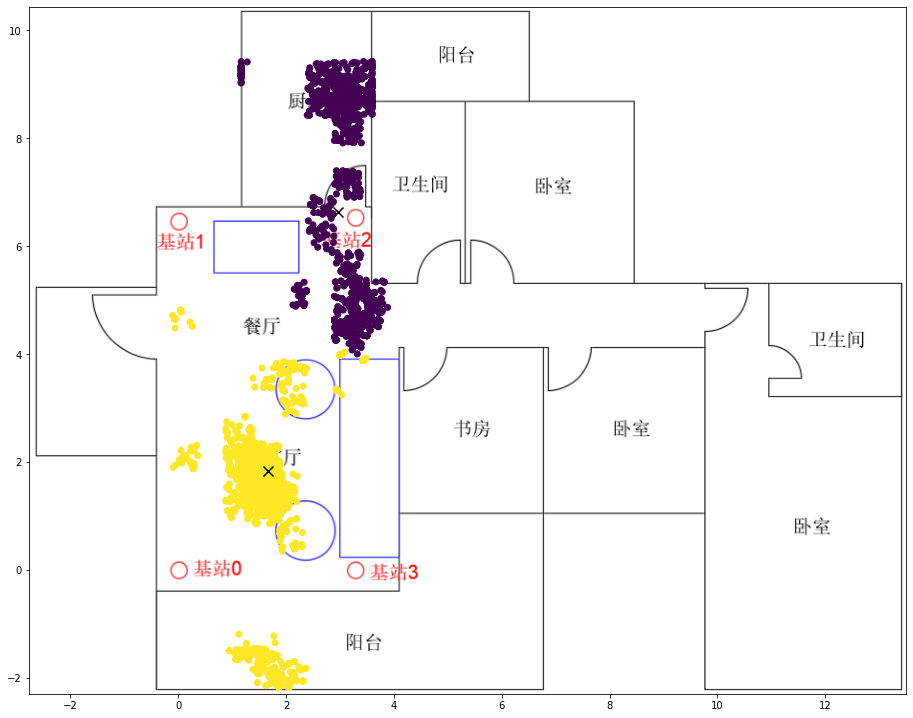

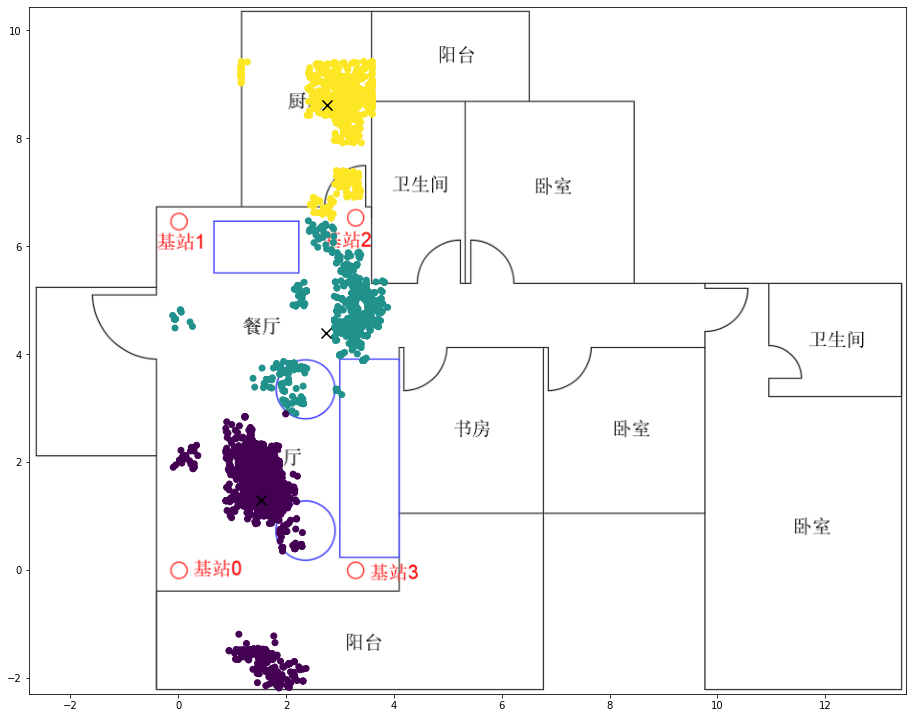

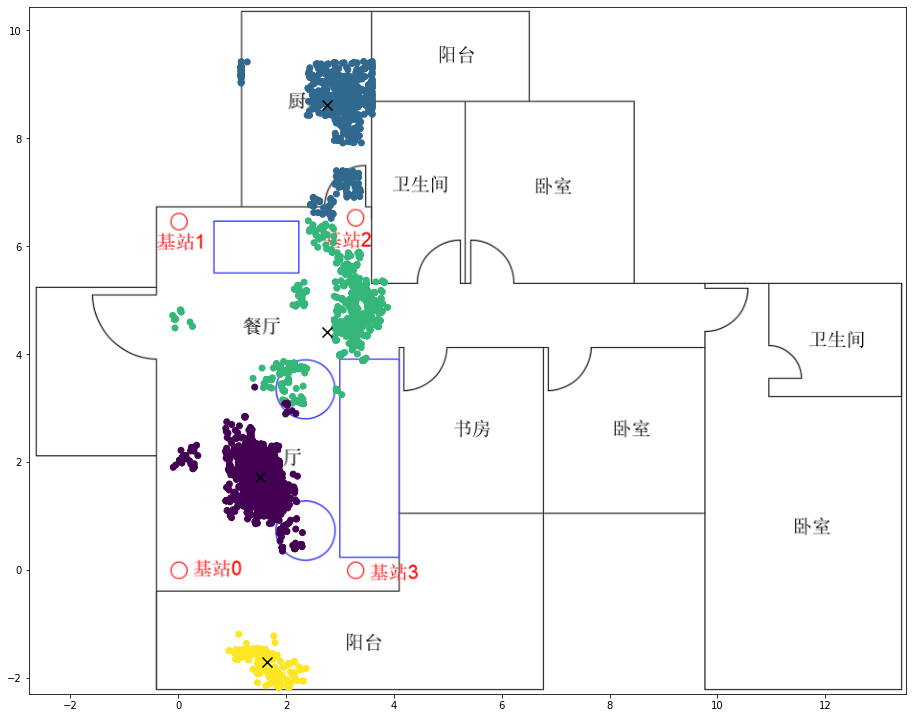

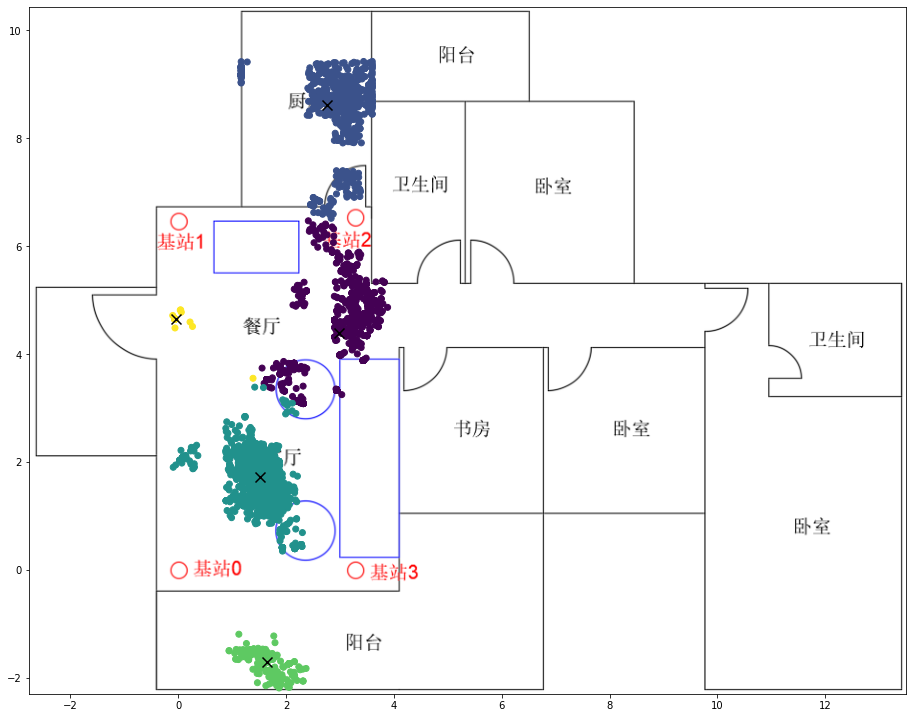

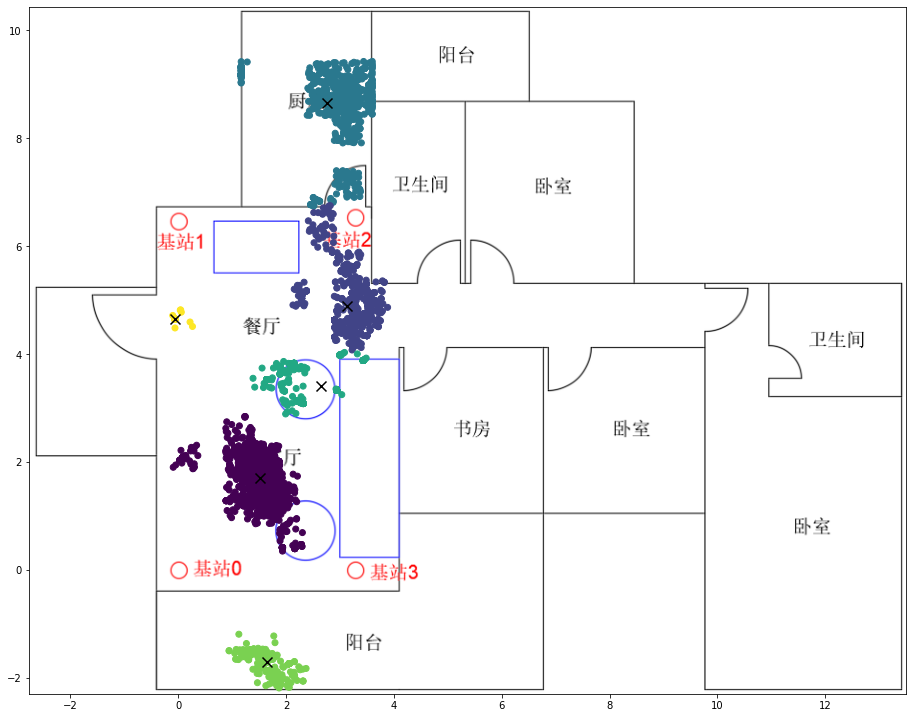

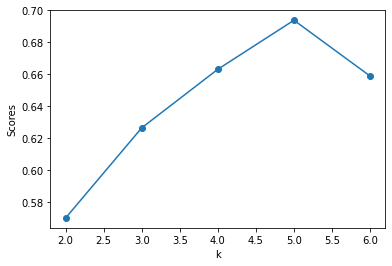

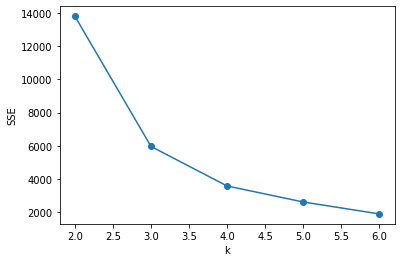

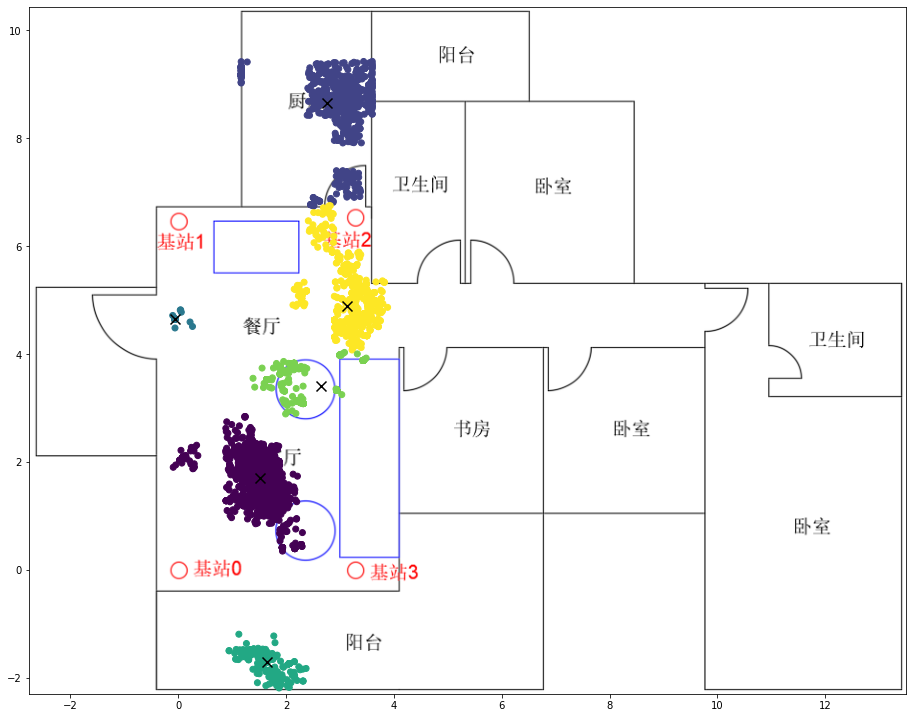

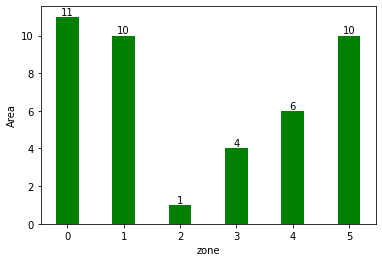

In [9]:
'''
整个14天的分区表示——聚类+画成热力图
'''
key="All"
data_allInOne = collectDataAllInOne(df_week)
groups,grids = createGrid(data_allInOne,key)
createHeatmap(grids,"heatmap_allInOne")

 # 删去点数小于min_count的网格中的点——剩余的点更加集中，便于聚类
choice_data_all=choose_spots(data_allInOne,groups,40)
x=choice_data_all['x']
y=choice_data_all['y']
# centers: 聚类后每一类的中心点坐标——根据中心点划定zone的范围
centers_all,y_pre_all = K_m(x,y,key)
choice_data_all['zone']=y_pre_all


dict_zones_all= get_dict_zones(choice_data_all,number_cluster[key])
zones_info_forall=get_zone_info("All",dict_zones_all)
intervals_in_zones,details = getTimeIntervalsForZones(dict_zones_all,data_allInOne)

new_grids = createHeatmapByTime(dict_zones_all,"heatmap_allInOne")
createHeatmapByTime2(new_grids,"heatmap_allInOne")


In [10]:
'''
按在家时间长短分为两类分析
首先处理数据，将数据分为两类并整合
'''
list_long_df=[]
list_short_df=[]

for idx,row in totaltimes.iterrows():
    if row['TimeAtHome']>500:
        list_long_df.append(collectData(dict_df,row['date']))
    else:
        list_short_df.append(collectData(dict_df,row['date']))

df_long = pd.concat(list_long_df,sort=False)
df_long.reset_index(drop=True, inplace=True) 

df_short = pd.concat(list_short_df,sort=False)
df_short.reset_index(drop=True, inplace=True) 



time interval in all zones {0: 214, 1: 189, 2: 106, 3: 52, 4: 264, 5: 25}
time interval in all zones {0: 140, 1: 114, 2: 21, 3: 36}
===========> DONE <===========


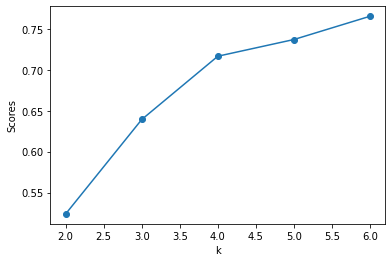

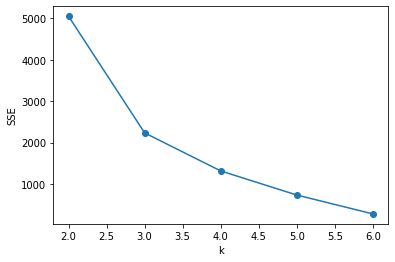

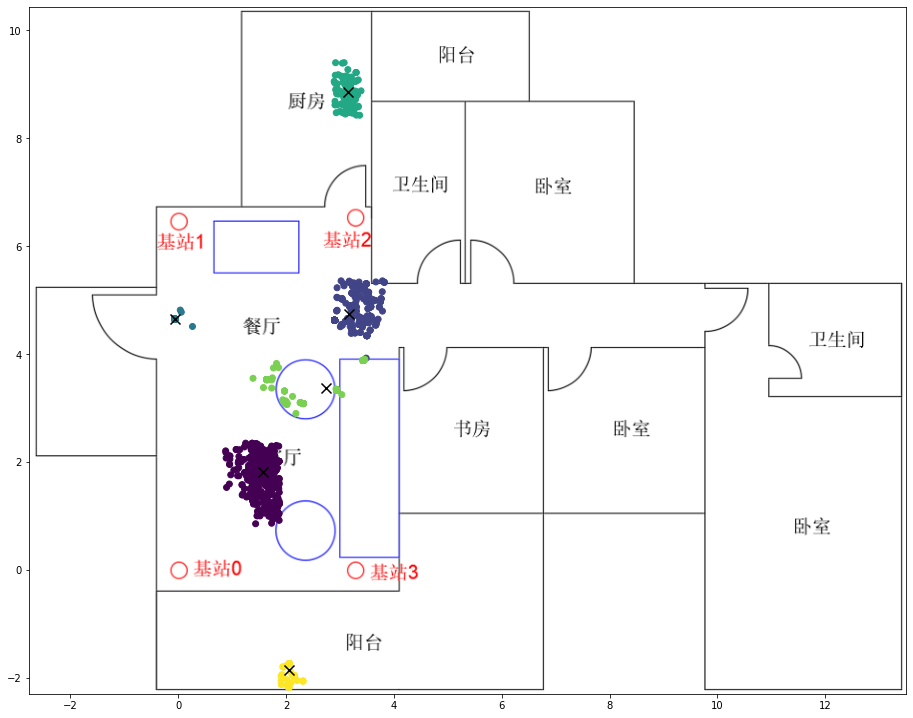

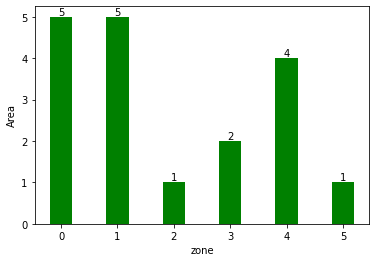

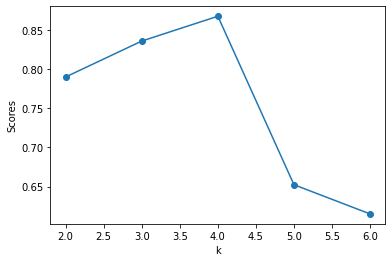

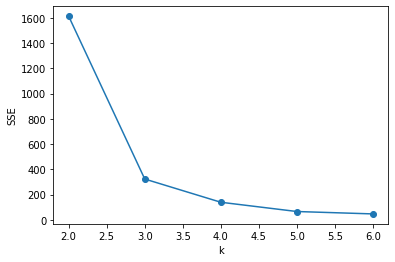

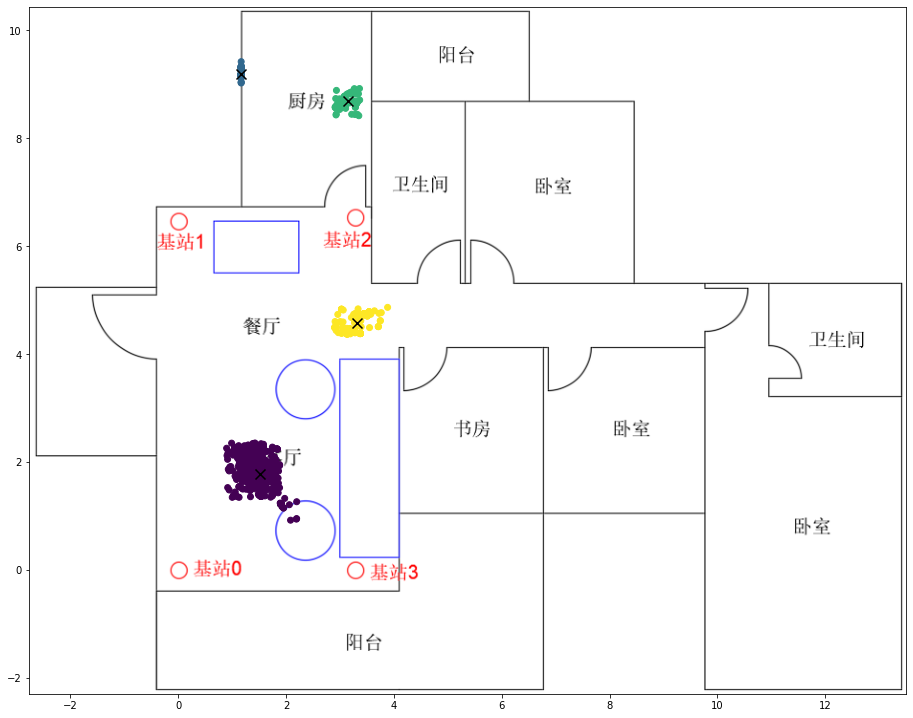

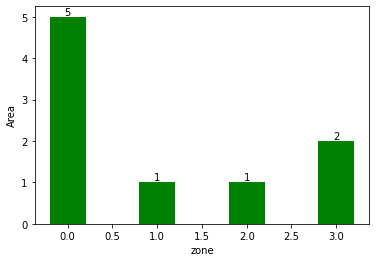

In [11]:
'''
长时段在家的情况：totaltimes[key]>500
'''
zones_long=FinalAnalysis(df_long,"long",len(list_long_df)*10)

'''
短时段在家的情况：totaltimes[key]<500
'''
zones_short=FinalAnalysis(df_short,"short",len(list_short_df)*min_count)

print("===========> DONE <===========")
